In [ ]:
from google.colab import files
files.upload() # Select kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdruhulaminbishal","key":"91b72e11352c246c4e330a8848a0d505"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading dataset
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [01:09<00:00, 244MB/s]
100% 3.75G/3.75G [01:09<00:00, 58.2MB/s]


In [ ]:
!unzip -q 140k-real-and-fake-faces.zip
print("Data unzipped and ready!")

Data unzipped and ready!


In [ ]:
import os

# Define paths
base_dir = 'real_vs_fake/real-vs-fake'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'valid')

# Checking how many images we have
print("Training Real:", len(os.listdir(os.path.join(train_dir, 'real'))))
print("Training Fake:", len(os.listdir(os.path.join(train_dir, 'fake'))))

Training Real: 50000
Training Fake: 50000


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models, optimizers
import os

# Configuration
IMG_SIZE = 299
BATCH_SIZE = 64
EPOCHS = 8

base_dir = 'real_vs_fake/real-vs-fake'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# 1. Creating Generators (Rescaling is crucial for convergence)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True # Data augmentation: flips images to help model generalize
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Link Generators to Folders
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary because we only have 2 classes: Real vs Fake
    shuffle=True
)

print("Loading Validation Data:")
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("Loading Test Data:")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Don't shuffle test data so we can evaluate cleanly later
)

Loading Training Data:
Found 100000 images belonging to 2 classes.
Loading Validation Data:
Found 20000 images belonging to 2 classes.
Loading Test Data:
Found 20000 images belonging to 2 classes.


In [ ]:
# 1. Load the pre-trained Xception model (excluding the top layers)
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# 2. Freeze the base model
# We don't want to retrain Xception from scratch, we just want to use it as a feature extractor.
base_model.trainable = False

# 3. Add our custom classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Condenses information
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),             # Prevents overfitting
    layers.Dense(1, activation='sigmoid') # Output: 0-1 probability
])

# 4. Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1011s 615ms/step - accuracy: 0.7576 - loss: 0.4966 - val_accuracy: 0.8345 - val_loss: 0.3748
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 915s 585ms/step - accuracy: 0.8246 - loss: 0.3880 - val_accuracy: 0.8440 - val_loss: 0.3504
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 916s 586ms/step - accuracy: 0.8447 - loss: 0.3536 - val_accuracy: 0.8619 - val_loss: 0.3181
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 915s 586ms/step - accuracy: 0.8576 - loss: 0.3292 - val_accuracy: 0.8585 - val_loss: 0.3206
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 915s 585ms/step - accuracy: 0.8633 - loss: 0.3153 - val_accuracy: 0.8783 - val_loss: 0.2851
Epoch 6/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 915s 586ms/step - accuracy: 0.8713 - loss: 0.3013 - val_accuracy: 0.8803 - val_loss: 0.2796
Epoch 7/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 916s 586ms/step - accuracy: 0.8744 - loss: 0.2904 - val_accuracy: 0.8839 - val_loss: 0.2772
Epoch 8/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 916s 586ms/step - accuracy:

Model saved successfully!


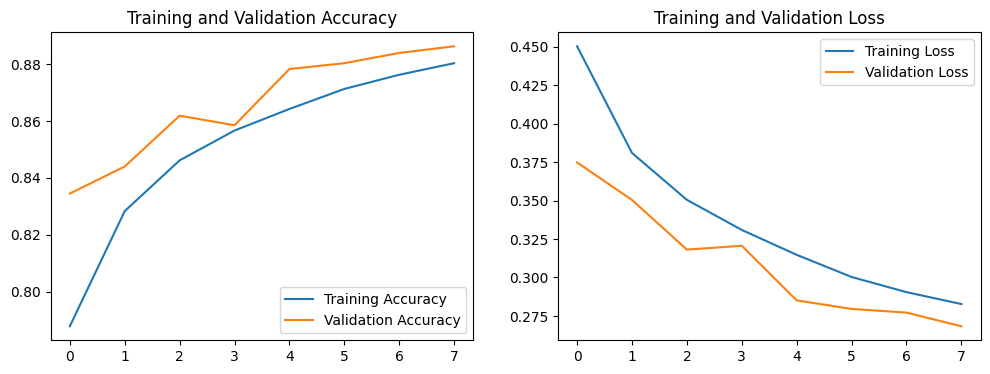

In [ ]:
import matplotlib.pyplot as plt

# 1. Save the model
model.save('deepfake_xception_model.h5')
print("Model saved successfully!")

# 2. Plot Accuracy (Use this image in your slide!)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Generating predictions for the test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 176s 527ms/step

--- Classification Report ---
              precision    recall  f1-score   support

        fake       0.88      0.89      0.89     10000
        real       0.89      0.88      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



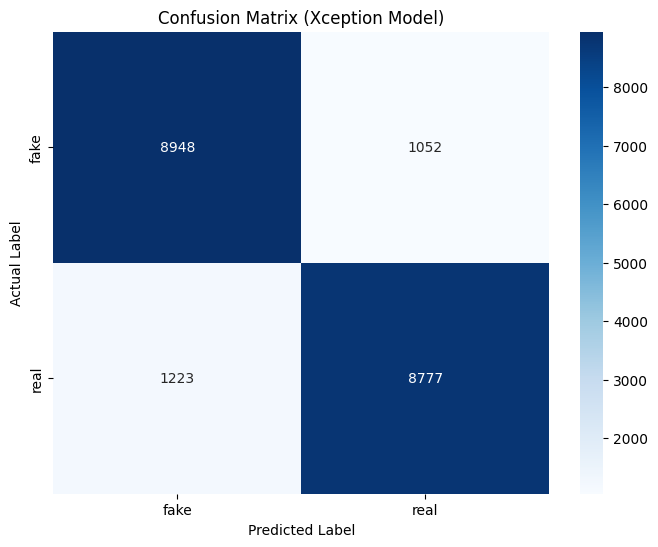

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Get predictions on the Test Set
print("Generating predictions for the test set...")
# predict_generator is deprecated, using predict
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0) # Convert probabilities to 0 or 1

# 2. Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) # ['fake', 'real']

# 3. specific detailed report (Precision/Recall/F1-Score)
print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 4. Generate Confusion Matrix Heatmap
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Xception Model)')
plt.show()

In [ ]:
import random

def simulate_video_prediction(generator, num_frames=10):
    """
    Simulates a video by taking a random batch of frames from the test set
    and checking for temporal consistency.
    """
    # Grab a random batch of images
    x, y = next(generator)

    # Pick 'num_frames' random images from this batch to represent a "Video Clip"
    # (In a real app, these would be consecutive frames)
    indices = random.sample(range(len(x)), num_frames)
    selected_frames = x[indices]
    actual_labels = y[indices]

    # Predict on these frames
    preds = model.predict(selected_frames)
    pred_labels = np.where(preds > 0.5, 1, 0).flatten()

    # Calculate "Video" Score
    fake_count = np.sum(pred_labels == 0) # Assuming 0 is Fake (check your class indices)
    real_count = np.sum(pred_labels == 1)

    print(f"Analyzing 'Video' Clip of {num_frames} frames...")
    print(f"Frame Predictions: {pred_labels}")
    print(f"Votes -> Fake: {fake_count}, Real: {real_count}")

    # Temporal Decision Logic
    if fake_count > real_count:
        final_decision = "FAKE VIDEO"
    else:
        final_decision = "REAL VIDEO"

    print(f"Final Temporal Decision: {final_decision}")
    return selected_frames

# Run the simulation
# Run this cell a few times to see different "videos"
frames = simulate_video_prediction(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Analyzing 'Video' Clip of 10 frames...
Frame Predictions: [0 0 0 0 0 0 0 0 0 0]
Votes -> Fake: 10, Real: 0
Final Temporal Decision: FAKE VIDEO


In [ ]:
from google.colab import files
files.download('deepfake_xception_model.h5')